# IRIS Flower Classification

## Introduction

The Iris dataset is a popular choice for classification tasks in machine learning. It contains measurements of four features (sepal length, sepal width, petal length, and petal width) of iris flowers belonging to three different species: setosa, versicolor, and virginica.

Our goal is to build a machine learning model that can accurately classify iris flowers into their respective species based on these four features. This is a supervised learning problem, as we have labeled data with the correct species for each sample. Since we are predicting a categorical variable (the species), this is a classification task.

We will explore different classification algorithms, such as k-nearest neighbors, decision trees, and logistic regression, to determine which model performs best on the Iris dataset. By the end of this project, we aim to build a model that can accurately classify iris flowers based on their measurements.


## Table of Contents
---
- [Introduction](#Introduction)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Cleaning](#Data-Cleaning)
- [Data Visualization](#Data-Visualization)
- [Data Preprocessing](#Data-Preprocessing)
- [Model Preparation](#Model-Preparation)
- [Model Results](#Model-Results)
  - [Decision Tree](#Decision-Tree)
  - [KNN](#KNN)
  - [Random Forest](#Random-Forest)
  - [Support Vector Machine](#Support-Vector-Machine)
  - [Gradient Boosting](#Gradient-Boosting)
- [Best Performing Model](#Best-Performing-Model)  
- [Partial Dependence Plots](#Partial-Dependence-Plots)
- [Discussion and Recommendations](#Discussion-and-Recommendations)

## Introduction

## Exploratory Data Analysis
We start by installing the necessary modules and importing the necessary libraries.

In [1]:
%%capture
!pip install pandas
!pip install sqlite3
!pip install sqlalchemy
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from scipy import stats, interp
from sqlalchemy import create_engine
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

# Read the full contents of the dataframes
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = None

Next, we will load the data into a SQLite database. We will be working with the [Iris Dataset](https://archive.ics.uci.edu/dataset/53/iris) from the UC Irvine Machine Learning Repository. This dataset contains plant information in a file named `IRIS.csv`.

In [3]:
# Load the IRIS CSV file into a DataFrame
iris_df = pd.read_csv('IRIS.csv')

# Create an SQLite engine
engine = create_engine('sqlite:///iris.db')

# Load the DataFrame into the SQLite database
iris_df.to_sql('iris', engine, index=False, if_exists='replace')

# Look at shape of the dataframe
iris_df.shape


(152, 5)

In [4]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  152 non-null    float64
 1   sepal_width   152 non-null    float64
 2   petal_length  152 non-null    object 
 3   petal_width   152 non-null    object 
 4   species       151 non-null    object 
dtypes: float64(2), object(3)
memory usage: 6.1+ KB


We can see that there are 152 records and 5 columns. Four columns are numeric and represent continuous data while the `species` column is categorical and stores one of three different flower types (setosa, versicolour, and virginica). The column data is as follows:

- `sepal_length:` the sepal length (in cm)
- `sepal_width:` the sepal width (in cm)
- `petal_length:` the petal length (in cm)
- `petal_width:` the pedal width (in cm)
- `species:` the type of flower (one of setosa, versicolour, or virginica)

## Cleaning the Data

We will now examine null records.

In [6]:
# Check for missing values
missing_values = iris_df.isna().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         1
dtype: int64


In [7]:
# Determine rows with null values
null_rows = iris_df[iris_df.isna().any(axis=1)]
print(null_rows)

    sepal_length  sepal_width petal_length  petal_width species
22           3.7          1.5          0.4  Iris-setosa     NaN


The species in row 22 is missing. From reviewing other data, we can see that the species was put inside the `pedal_width` column and that we should shift the other columns to the right and replace the `sepal_length` column. We now fix the missing values.

In [8]:
# Calculate the average sepal length
avg_sepal_length = iris_df['sepal_length'].mean()

# Define a function to shift columns to the right for rows with null species
def shift_row(row):
    if pd.isnull(row['species']):
        return pd.Series([row['petal_width'], row['petal_length'],
                          row['sepal_width'], row['sepal_length'],
                          avg_sepal_length],
                         index=['species', 'petal_width', 'petal_length',
                                'sepal_width', 'sepal_length'])
    return row


# Apply the function to each row
iris_df = iris_df.apply(shift_row, axis=1)

# Confirm no missing values remain
missing_values_after = iris_df.isnull().sum()
print("Missing values after handling:\n", missing_values_after)

Missing values after handling:
 petal_length    0
petal_width     0
sepal_length    0
sepal_width     0
species         0
dtype: int64


We now re-examine row 22.

In [9]:
print(iris_df.iloc[22])

petal_length            1.5
petal_width             0.4
sepal_length       5.831579
sepal_width             3.7
species         Iris-setosa
Name: 22, dtype: object


Let's also make sure that all of the numerical columns have valid numerical data. If these aren't valid numerical data, we will replace the data with the column mean.

In [10]:
# Convert 'pedal length, petal_width, sepal_length, and sepal_width' to numeric,
# setting errors='coerce' will convert non-numeric values to NaN
iris_df['petal_length'] = pd.to_numeric(iris_df['petal_length'], errors='coerce')
iris_df['petal_width'] = pd.to_numeric(iris_df['petal_width'], errors='coerce')
iris_df['sepal_length'] = pd.to_numeric(iris_df['sepal_length'], errors='coerce')
iris_df['sepal_width'] = pd.to_numeric(iris_df['sepal_width'], errors='coerce')

In [11]:
# Calculate the mean of the 'pedal length' column, ignoring NaN values
mean_pedal_length = iris_df['petal_length'].mean()

# Replace NaN values (which were originally strings like "A") with the mean
iris_df['petal_length'].fillna(mean_pedal_length, inplace=True)

## Reviewing Summary Statistics

In [12]:
# Generate summary statistics
summary_stats = iris_df.describe()
print("Summary Statistics:\n", summary_stats)

# Check for unique values in categorical column
unique_species = iris_df['species'].unique()
print("Unique species:\n", unique_species)

Summary Statistics:
        petal_length  petal_width  sepal_length  sepal_width
count    152.000000   152.000000    152.000000   152.000000
mean       3.743709     1.195395      5.845602     3.052632
std        1.762245     0.761259      0.823073     0.439438
min        1.000000     0.100000      4.300000     2.000000
25%        1.575000     0.300000      5.100000     2.800000
50%        4.300000     1.300000      5.800000     3.000000
75%        5.100000     1.800000      6.400000     3.300000
max        6.900000     2.500000      7.900000     4.400000
Unique species:
 ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [13]:
iris_df.describe().T

,count,mean,std,min,25%,50%,75%,max
petal_length,152.0,3.743709,1.762245,1.0,1.575,4.3,5.1,6.9
petal_width,152.0,1.195395,0.761259,0.1,0.300,1.3,1.8,2.5
sepal_length,152.0,5.845602,0.823073,4.3,5.100,5.8,6.4,7.9
sepal_width,152.0,3.052632,0.439438,2.0,2.800,3.0,3.3,4.4


## Exploring the Data


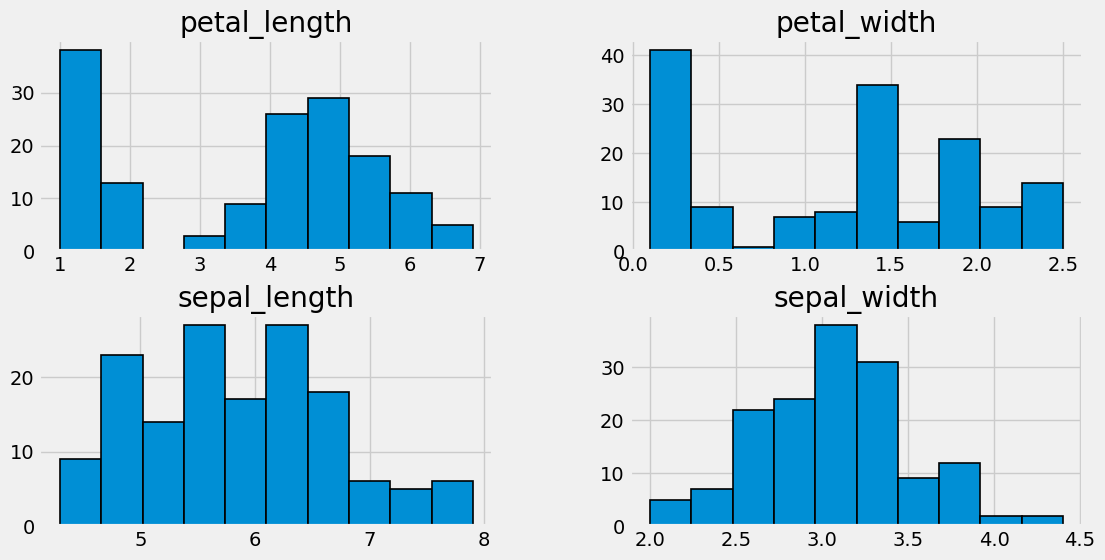

In [14]:
iris_df.hist(edgecolor='black', linewidth=1.2)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

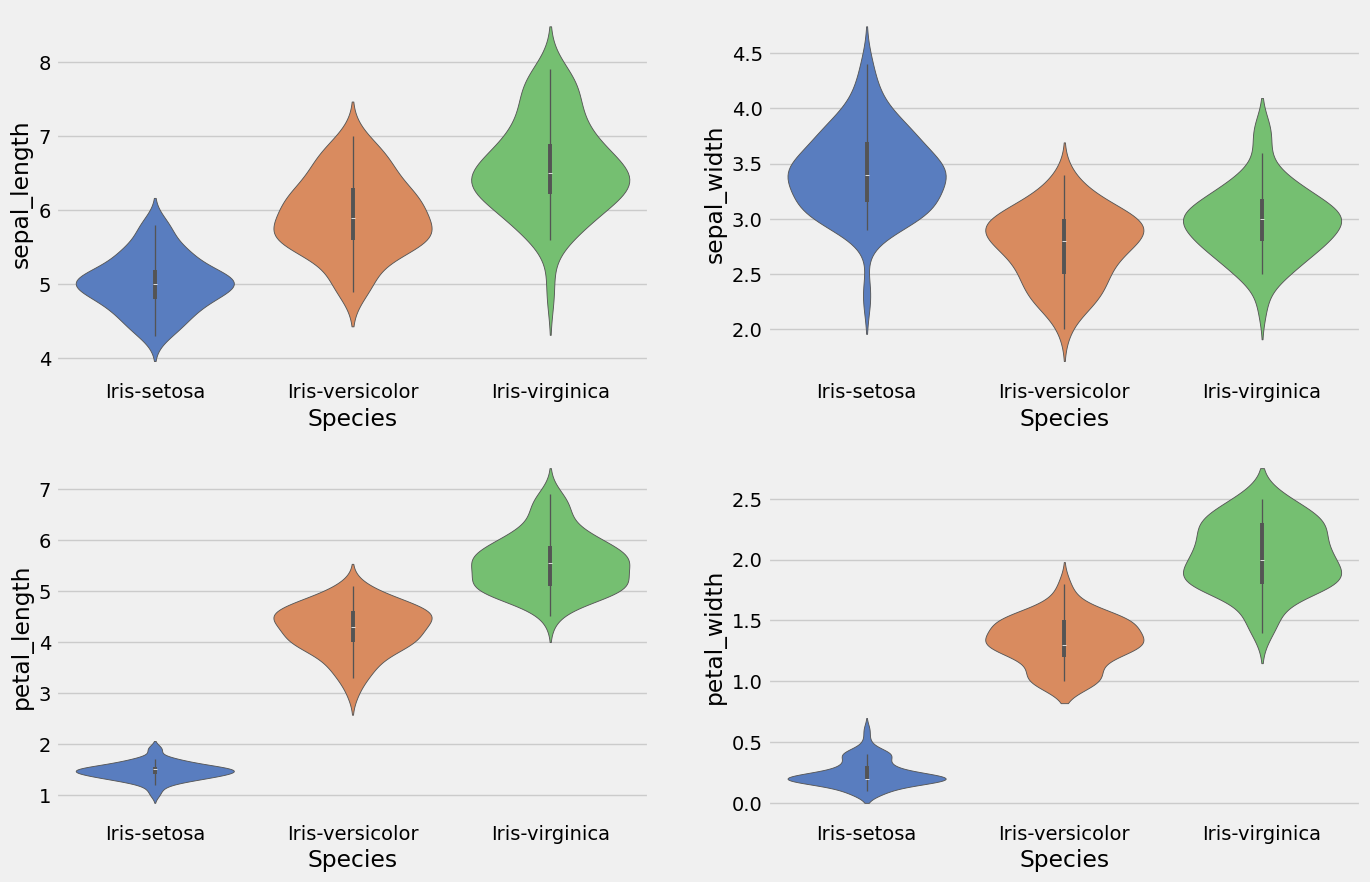

In [15]:
# Define a function to create a violin plot
def plot_violin(subplot_position, y):
    plt.subplot(subplot_position)
    ax = sns.violinplot(x='species', y=y, data=iris_df, hue='species', palette='muted', legend=False)
    ax.set_xlabel('Species')

# Set up the figure size
plt.figure(figsize=(15, 10))

# Define features for the plots
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Create the violin plots
for i, feature in enumerate(features, start=1):
    plot_violin(220 + i, feature)

## Data Preprocessing

In [27]:
# Encode the species column into numerical values
le = LabelEncoder()
iris_df['species'] = le.fit_transform(iris_df['species'].astype(str))

print(iris_df['species'].value_counts())
print('\n{}'.format(iris_df.info()))

species
0    51
1    51
2    50
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   petal_length  152 non-null    float64
 1   petal_width   152 non-null    float64
 2   sepal_length  152 non-null    float64
 3   sepal_width   152 non-null    float64
 4   species       152 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.1 KB

None


We will now use a heatmap to visualize correlation between columns. We will look at the correlation between all numerical columns and the `species` column (which will be the target variable in our machine learning models).

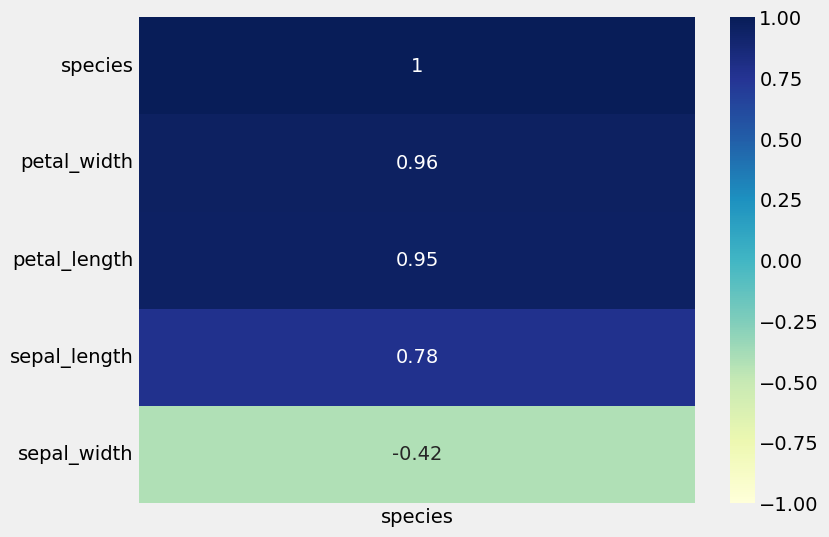

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
corr_matrix = np.abs(iris_df.corr())
sns.heatmap(iris_df.corr()[['species']].sort_values('species').tail(10),
 vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax);
ax.invert_yaxis()

Here we see that highly correlated features are `petal_width`, `pedal_length`, and `sepal_length.` Features that are less correlated are `sepal_width`. For now, we will not drop these columns.

## Model Preparation

We will now separate our data into features and a target. We will choose the flower species as our target variable. The features will be the remaining four columns which we will use to predict the flower species.

Next, we are going to split our data into train and test and look at the shape of the resulting datasets.

In [21]:
X = iris_df.drop('species', axis=1)
y = iris_df['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Size of X_train: ", X_train.shape)
print("Size of X_test: ", X_test.shape)
print("Size of y_train: ", y_train.shape)
print("Size of y_test: ", y_test.shape)

Size of X_train:  (106, 4)
Size of X_test:  (46, 4)
Size of y_train:  (106,)
Size of y_test:  (46,)


Before we start building various machine learning models, we will look at a baseline model to see how well our models perform. Our baseline will be to predict all flowers as one of the three types. Say that we predict all of the flowers are of type `setosa`.

In [67]:
# Set all predictions to be 'setosa'
y_pred_setosa = [0] * len(y)

# Calculate the accuracy
accuracy = accuracy_score(y, y_pred_setosa)

print("Accuracy of predicting all flower species as 'setosa': {:.2f}%".format(accuracy * 100))

Accuracy of predicting all flower species as 'setosa': 33.55%


Then, we see that our machine learning models are only useful if they can achieve an accuracy better than 33%.

## Model Results

We will look at a variety of standard supervised learning algorithms. First, we create three helper functions.

In [22]:
# Capture k-fold output in a dataframe for comparisons
kfold_accuracy_df = pd.DataFrame(columns=['Model','Fold_1','Fold_2','Fold_3','Fold_4','Fold_5'])
kfold_f1_df = pd.DataFrame(columns=['Model','Fold_1','Fold_2','Fold_3','Fold_4','Fold_5'])

In [23]:
# Returns a dictionary of statistics to compare model accuracy provided that
# five folds are defined.
def kfold_xval(model,train_data,target_data,**kwargs):
    num_folds = kwargs.get('num_folds',10)
    ret_5 = kwargs.get('ret_5',num_folds==5)
    print("Cross-validation using {} folds".format(num_folds))
    accuracy_array = cross_val_score(model, train_data, target_data, scoring="accuracy", cv=num_folds)
    if ret_5:
        ret_dict = {'Model': str(model),
                    'Fold_1': accuracy_array[0],
                    'Fold_2': accuracy_array[1],
                    'Fold_3': accuracy_array[2],
                    'Fold_4': accuracy_array[3],
                    'Fold_5': accuracy_array[4],
                   }
        print("Accuracy:", ret_dict)
        return(ret_dict)
    else:
        print(accuracy_array)

In [24]:
# Returns a dictionary of statistics to compare model F1 score provided that
# five folds are defined.
def kfold_xval_f1(model, train_data, target_data, **kwargs):
    num_folds = kwargs.get('num_folds', 10)
    ret_5 = kwargs.get('ret_5', num_folds == 5)
    print("Cross-validation using {} folds".format(num_folds))
    f1_array = cross_val_score(model, train_data, target_data, scoring="f1_macro", cv=num_folds)
    if ret_5:
        ret_dict = {'Model': str(model),
                    'Fold_1': f1_array[0],
                    'Fold_2': f1_array[1],
                    'Fold_3': f1_array[2],
                    'Fold_4': f1_array[3],
                    'Fold_5': f1_array[4],
                   }
        print("F1 Score:", ret_dict)
        return ret_dict
    else:
        print(f1_array)

In [54]:
def comp_train_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    # Make predictions
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_preds_test)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()

    # Classification metrics
    print("------------------------- Test set statistics -------------------------")
    print("Accuracy: {}".format(accuracy_score(y_test, y_preds_test)))
    print("Precision: {}".format(precision_score(y_test, y_preds_test, average='macro')))
    print("Recall: {}".format(recall_score(y_test, y_preds_test, average='macro')))
    print("F1 Score: {}".format(f1_score(y_test, y_preds_test, average='macro')))

In [62]:
def plot_roc(model, X_train, y_train, X_test, y_test):
    # Binarize the labels
    y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

    # Fit the model
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train, y_train_bin).predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_train_bin.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

We now test our model using several supervised learning algorithms including Decision Tree Clasification, KNN, Random Forest, Support Vector Machine, and Gradient Boosting. We will also test others.

#### Decision Tree

In [55]:
decision_tree = DecisionTreeClassifier()
cv_results = kfold_xval(decision_tree,X_train,y_train,num_folds=5)
kfold_accuracy_df = pd.concat([kfold_accuracy_df, pd.DataFrame.from_records([cv_results])])

Cross-validation using 5 folds
Accuracy: {'Model': 'DecisionTreeClassifier()', 'Fold_1': 0.9545454545454546, 'Fold_2': 1.0, 'Fold_3': 0.9523809523809523, 'Fold_4': 0.9047619047619048, 'Fold_5': 0.9523809523809523}


In [56]:
f1_results = kfold_xval_f1(decision_tree,X_train,y_train,num_folds=5)
kfold_f1_df = pd.concat([kfold_f1_df, pd.DataFrame.from_records([f1_results])])

Cross-validation using 5 folds
F1 Score: {'Model': 'DecisionTreeClassifier()', 'Fold_1': 0.9547511312217195, 'Fold_2': 1.0, 'Fold_3': 0.952136752136752, 'Fold_4': 0.9107142857142857, 'Fold_5': 0.9500891265597148}


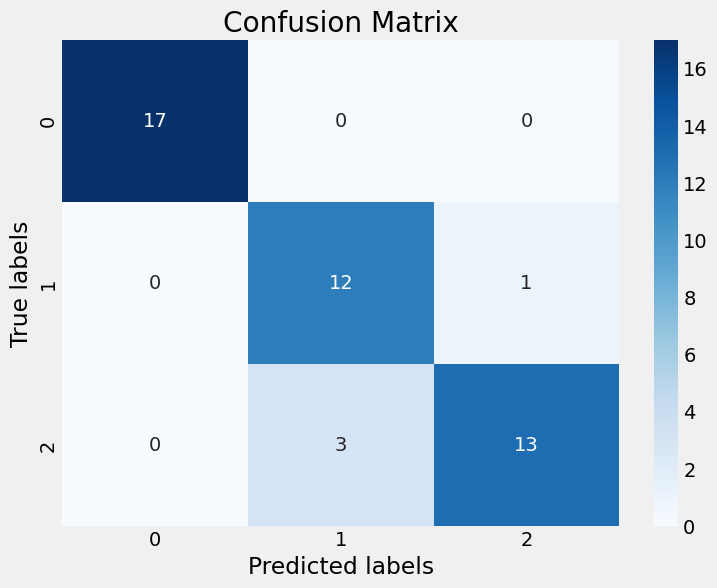

------------------------- Test set statistics -------------------------
Accuracy: 0.9130434782608695
Precision: 0.9095238095238095
Recall: 0.9118589743589745
F1 Score: 0.9079365079365079


In [57]:
comp_train_test(decision_tree,X_train,y_train,X_test,y_test)

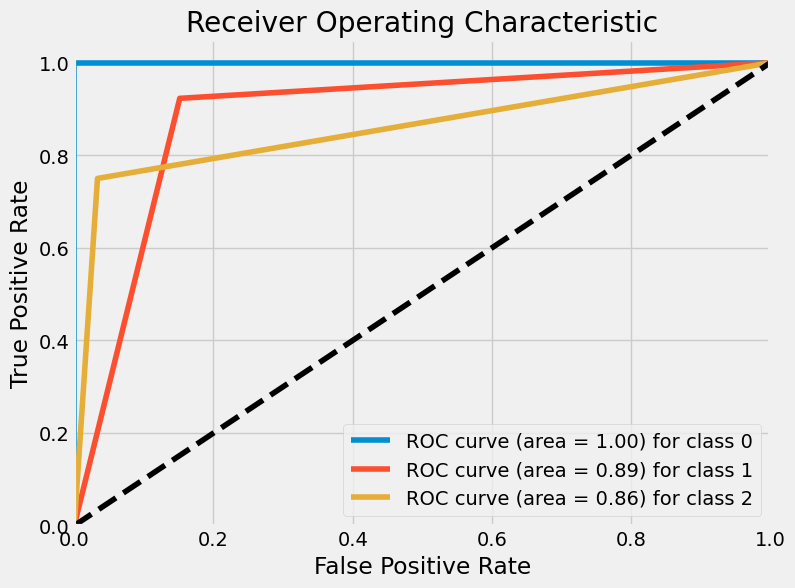

In [65]:
plot_roc(decision_tree,X_train,y_train,X_test,y_test)

#### KNN

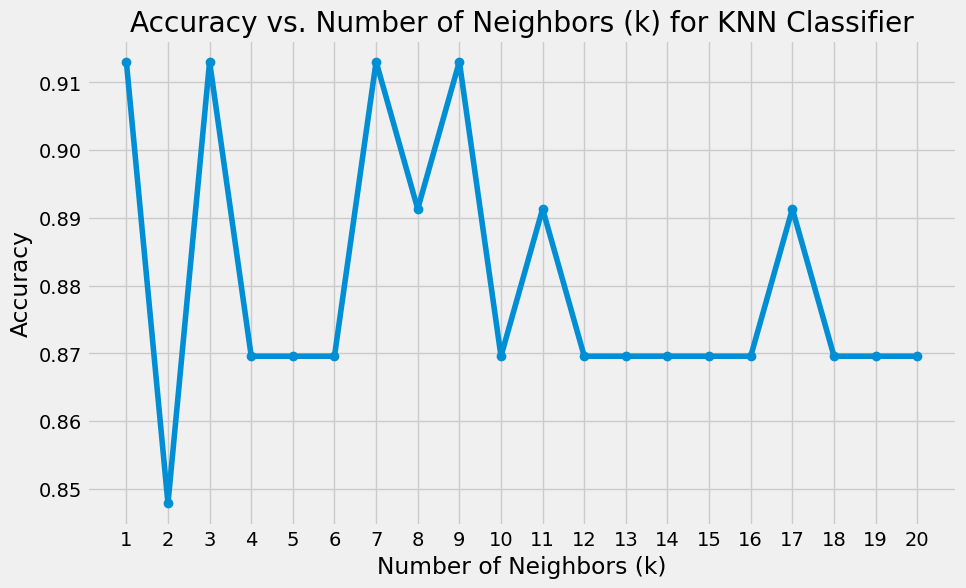

In [58]:
# Find the accuracy for different values of k
k_values = np.arange(1, 21)  # Values of k from 1 to 20
accuracy_values = []  # Store accuracy values for different k
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_values.append(accuracy)

# Plot the accuracy vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_values, marker='o')
plt.title('Accuracy vs. Number of Neighbors (k) for KNN Classifier')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Nine neighbors looks reasonable.

In [59]:
knn = KNeighborsClassifier(n_neighbors = 9)
cv_results = kfold_xval(decision_tree,X_train,y_train,num_folds=5)
kfold_accuracy_df = pd.concat([kfold_accuracy_df, pd.DataFrame.from_records([cv_results])])

Cross-validation using 5 folds
Accuracy: {'Model': 'DecisionTreeClassifier()', 'Fold_1': 0.9545454545454546, 'Fold_2': 1.0, 'Fold_3': 0.9523809523809523, 'Fold_4': 0.9047619047619048, 'Fold_5': 0.9523809523809523}


In [60]:
f1_results = kfold_xval_f1(knn,X_train,y_train,num_folds=5)
kfold_f1_df = pd.concat([kfold_f1_df, pd.DataFrame.from_records([f1_results])])

Cross-validation using 5 folds
F1 Score: {'Model': 'KNeighborsClassifier(n_neighbors=9)', 'Fold_1': 1.0, 'Fold_2': 1.0, 'Fold_3': 1.0, 'Fold_4': 0.9547511312217195, 'Fold_5': 1.0}


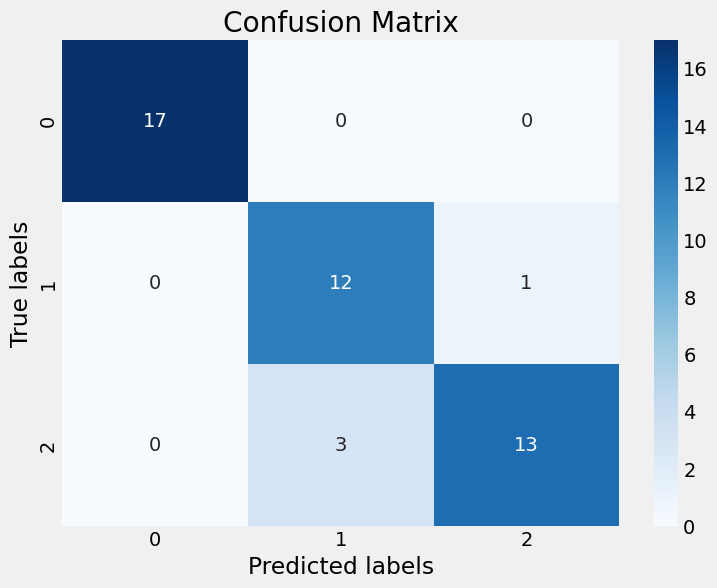

------------------------- Test set statistics -------------------------
Accuracy: 0.9130434782608695
Precision: 0.9095238095238095
Recall: 0.9118589743589745
F1 Score: 0.9079365079365079


In [61]:
comp_train_test(knn,X_train,y_train,X_test,y_test)

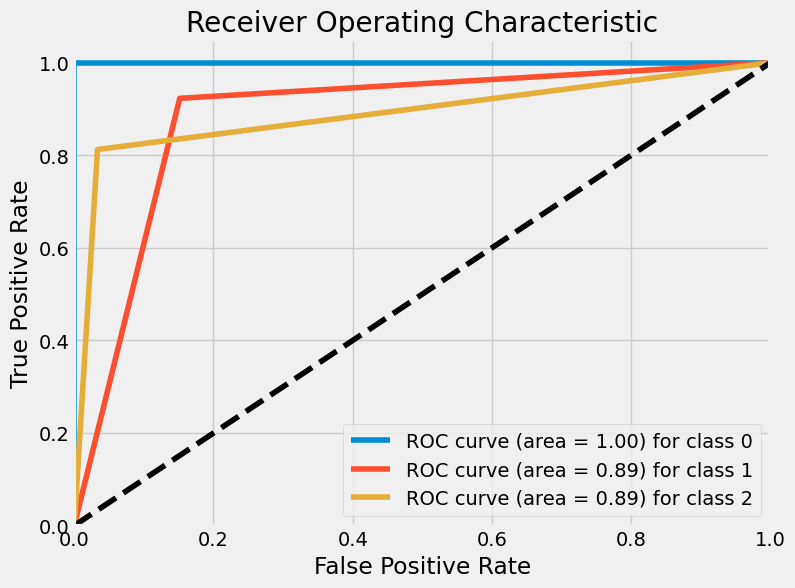

In [66]:
plot_roc(decision_tree,X_train,y_train,X_test,y_test)